In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from ngsolve.meshes import MakeStructured2DMesh

importing NGSolve-6.2.2204


In [2]:
L  = 1
t  = Parameter(0.01)

E  = 1e6
nu = 0.3
k  = 5/6

G = E/(2*(1+nu))
        
q = sin(pi*x/L)

In [3]:
def GetExSolution(t):
    w_ex = 0.112104526221152940265548393276936140028759596241*sin(pi*x) + 0.000632409771566098572843110743663530806201297944823*cosh(pi*y)*sin(pi*x) + 0.0137001636773051064646072440194929287608001683819*y*sinh(pi*y)*sin(pi*x) - 0.0000316122092964093846904903925214350233381599376977*sin(pi*x)*(0.0778005614549296617758704561411247100184621005913*cosh(pi*y) - 1.)
    bx = -0.352186756010538421893888815359115479436251630729*cos(pi*x) - 0.00198677389241045458752509183859938924329787256447*cosh(pi*y)*cos(pi*x) - 0.0430403335615994492112989782730640026686362137495*y*sinh(pi*y)*cos(pi*x) + 7.62933329113248462226480296578731364181334216691*10**(-72)*cosh(316.243370846569824755438139785423222466896713500*y)*cos(pi*x)
    by = -0.0156869375697155610521323358580923180040980409464*sinh(pi*y)*sin(pi*x) - 0.0430403335615994492112989782730640026686362137495*y*cosh(pi*y)*sin(pi*x) + 7.57905449687304576716760045185638770870950062624*10**(-74)*sinh(316.243370846569824755438139785423222466896713500*y)*sin(pi*x)
    return w_ex, CF( (bx,by) )

In [4]:
nx = 20
nlayer = 2
scale = t.Get()
ratio = (nlayer/nx)
            
mapping = lambda x,y: (L/2*x,L/2*y/ratio*scale -L/2 if y < ratio else L/2*((1-scale)/(1-ratio)*y+(scale-ratio)/(1-ratio))-L/2)
mapping2 = lambda x,y: (L/2*x,-L/2+L/2*y)
            
mesh = MakeStructured2DMesh(quads=False, nx=nx, ny=nx, mapping=mapping)

w_ex,beta_ex = GetExSolution(t.Get())
grad_w_ex = CF( (w_ex.Diff(x), w_ex.Diff(y)) )
curl_beta_ex = beta_ex[1].Diff(x)-beta_ex[0].Diff(y)

Draw(w_ex,mesh)
Draw(Norm(beta_ex),mesh)
shear = G*k*t.Get()*(grad_w_ex+beta_ex)
Draw(Norm(shear),mesh, order=4)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.22…

BaseWebGuiScene

In [5]:
def MaterialInv(mat):
    mu  = E / 2 / (1+nu)
    lam = E * nu / (1-nu**2)
    return 1/(2*mu)*(mat-1/2*Trace(mat)*Id(2))+1/(4*(lam+mu))*Trace(mat)*Id(2)

def SolveRM_TDNNS(mesh, order=1, draw=False):
    fesB = HCurl(mesh, order=order-1, dirichlet="left")
    fesS = HDivDiv(mesh, order=order-1, dirichlet="left|bottom")
    fesW = H1(mesh, order=order, dirichlet="left")

    fes = fesW*fesB*fesS
    (w,beta,sigma), (v,delta,tau) = fes.TnT()
    
    n = specialcf.normal(2)
    
    a = BilinearForm(fes, symmetric=True)
    a += (-12/t**3*InnerProduct(MaterialInv(sigma),tau) \
          + InnerProduct(tau,grad(beta)) + InnerProduct(sigma,grad(delta))-1e-8*beta*delta)*dx
    a += ( -(sigma*n*n)*(delta*n) - (tau*n*n)*(beta*n) )*dx(element_boundary=True)
    a += k*G*t*InnerProduct( grad(w)+beta, grad(v)+delta )*dx

    f = LinearForm(fes)
    f += q*v*dx

    gfsol = GridFunction(fes)
    gfw, gfbeta, gfsigma = gfsol.components
    
    with TaskManager():
        a.Assemble()
        f.Assemble()
        inv = a.mat.Inverse(fes.FreeDofs(), inverse="sparsecholesky")
        gfsol.vec.data = inv * f.vec
    if draw:
        Draw(gfw, mesh, "w")
        Draw(gfbeta[0], mesh, "beta_x")
    
    return gfw, gfbeta

In [6]:
errW = []
errB = []
hs = [0.5**i for i in range(1,6)]

order = 1

with TaskManager():
    
    for h in hs:
        mesh = MakeStructured2DMesh(quads=False, nx=int(L/h),ny=int(L/h), mapping=mapping2)
        gfw, gfbeta = SolveRM_TDNNS(mesh, order=order, draw=False)
        
        w_h1 = sqrt(Integrate(w_ex*w_ex+grad_w_ex*grad_w_ex, mesh))
        errw = sqrt(Integrate((gfw-w_ex)**2+(Grad(gfw)-grad_w_ex)**2,mesh))/w_h1
        errW.append(errw)

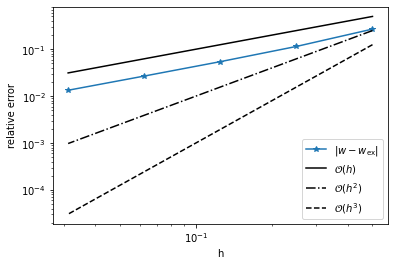

In [7]:
import matplotlib.pyplot as plt

plt.yscale('log')
plt.xscale('log')
plt.xlabel("h")
plt.ylabel("relative error")
plt.plot(hs,errW,"-*", label="$\|w-w_{\mathrm{ex}}\|$" )
    
plt.plot(hs,hs,"-",color="k", label="$\mathcal{O}(h)$")
plt.plot(hs,[h**2 for h in hs],"-.",color="k", label="$\mathcal{O}(h^2)$")
plt.plot(hs,[h**3 for h in hs],"--",color="k", label="$\mathcal{O}(h^3)$")
plt.legend()
plt.show()